# Generating a barrier change sequence

In generating a barrier sequence, there are a few things to think about. 

#### The barrier movement must meaningfully change the maze structure 

In all cases, each new maze needs to be different from the previous maze by the movement of a single barrier. We also want the environment to change such that the rat will adapt their behavior in some way (i.e. a barrier movement needs to meaningfully change the structure of the maze).


 To ensure the maze structure changes, we currently have 2 additional criteria for valid mazes created by a barrier change:
1. At least one path between reward ports must be longer AND one must be shorter.
2. The optimal path order must have changed (the pair of reward ports that used to be the closest together or furthest apart is now different).


These criteria are not mutually exclusive. For example, consider a starting maze with path lengths 15, 19, 23. A new maze with path lengths 17, 19, 21 satisfies criteria 1 but not criteria 2. Conversely, a new maze with path lengths 15, 19, 17 satisfies criteria 2 but not criteria 1. A new maze with path lengths 19, 17, 23 satisfies both criteria. 

When generating a barrier sequence, we can use the `criteria_type` argument to choose if new mazes must satisfy both (`"ALL"`) or either (`"ANY"`) of these criteria.

#### All mazes in a sequence must be sufficiently different

In a barrier sequence, each barrier set must be different enough from the previous barrier set, AND also different enough from all other previous mazes in the sequence.

To do this, we can set a threshold `min_hex_diff`: this is the combined minimum number of hexes that need to be different on optimal paths to reward ports between ALL mazes in a sequence.

(TODO: Add figure here explaining what that looks like)



### First, let's load our database of maze configurations

In [ ]:
import pandas as pd
import sys
sys.path.append("..")  # Use sys to add the parent directory (where hex_maze_utils lives) to the path

# Load the database and visualize it
df = pd.read_pickle('../Maze_Databases/maze_configuration_database.pkl')
display(df)

,barriers,len12,len13,len23,reward_path_lengths,path_length_difference,optimal_paths_12,optimal_paths_13,optimal_paths_23,optimal_paths_all,choice_points,num_choice_points,cycles,num_cycles,isomorphic_mazes
0,"(37, 39, 7, 41, 14, 46, 20, 23, 30)",15,17,21,"[15, 17, 21]",6,"[[1, 4, 6, 8, 10, 13, 17, 21, 26, 22, 27, 32, ...","[[1, 4, 6, 8, 10, 13, 16, 12, 15, 19, 24, 29, ...","[[2, 49, 38, 32, 27, 22, 26, 21, 17, 13, 16, 1...","[[1, 4, 6, 8, 10, 13, 17, 21, 26, 22, 27, 32, ...",{13},1,[],0,"{(37, 8, 9, 40, 20, 21, 22, 27, 28), (34, 8, 4..."
1,"(34, 36, 37, 39, 10, 45, 14, 15, 20)",17,21,19,"[17, 21, 19]",4,"[[1, 4, 5, 7, 9, 12, 16, 13, 17, 21, 26, 22, 2...","[[1, 4, 5, 7, 9, 12, 16, 13, 17, 21, 25, 30, 3...","[[2, 49, 38, 32, 27, 22, 26, 21, 25, 30, 35, 2...","[[1, 4, 5, 7, 9, 12, 16, 13, 17, 21, 26, 22, 2...",{21},1,[],0,"{(34, 37, 8, 40, 10, 15, 18, 20, 26), (34, 35,..."
2,"(34, 7, 41, 11, 46, 17, 20, 28, 31)",23,19,17,"[23, 19, 17]",6,"[[1, 4, 6, 8, 10, 13, 16, 12, 15, 19, 24, 29, ...","[[1, 4, 6, 8, 10, 13, 16, 12, 15, 19, 24, 29, ...","[[2, 49, 38, 32, 27, 22, 26, 21, 25, 30, 35, 4...","[[1, 4, 6, 8, 10, 13, 16, 12, 15, 19, 24, 29, ...",{35},1,"[[38, 49, 47, 42, 37, 32]]",1,"{(35, 7, 10, 44, 20, 22, 27, 28, 31), (32, 37,..."
3,"(34, 10, 42, 12, 45, 18, 23, 25, 31)",15,19,21,"[15, 19, 21]",6,"[[1, 4, 6, 8, 11, 14, 17, 21, 26, 22, 27, 32, ...","[[1, 4, 6, 8, 11, 14, 17, 13, 16, 20, 24, 29, ...","[[2, 49, 38, 32, 27, 22, 26, 21, 17, 13, 16, 2...","[[1, 4, 6, 8, 11, 14, 17, 21, 26, 22, 27, 32, ...",{17},1,[],0,"{(34, 37, 8, 40, 13, 46, 15, 18, 25), (34, 37,..."
4,"(39, 9, 10, 46, 21, 22, 23, 26, 30)",23,17,17,"[23, 17, 17]",6,"[[1, 4, 6, 8, 11, 14, 17, 13, 16, 20, 24, 29, ...","[[1, 4, 6, 8, 11, 14, 17, 13, 16, 20, 24, 29, ...","[[2, 49, 38, 32, 37, 31, 36, 41, 45, 40, 35, 2...","[[1, 4, 6, 8, 11, 14, 17, 13, 16, 20, 24, 29, ...",{29},1,"[[32, 38, 49, 47, 42, 37], [12, 15, 19, 24, 20...",2,"{(34, 36, 8, 41, 9, 21, 23, 27, 30), (10, 11, ..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
55891,"(34, 36, 7, 10, 42, 46, 19, 22, 25)",15,19,21,"[15, 19, 21]",6,"[[1, 4, 6, 8, 11, 14, 17, 21, 26, 31, 37, 32, ...","[[1, 4, 6, 8, 11, 14, 17, 13, 16, 20, 24, 29, ...","[[2, 49, 38, 32, 37, 31, 26, 21, 17, 13, 16, 2...","[[1, 4, 6, 8, 11, 14, 17, 21, 26, 31, 37, 32, ...",{17},1,[],0,"{(34, 37, 7, 40, 9, 42, 14, 16, 25), (35, 37, ..."
55892,"(37, 7, 9, 13, 45, 16, 22, 25, 29)",17,19,15,"[17, 19, 15]",4,"[[1, 4, 6, 8, 11, 14, 17, 21, 26, 31, 36, 41, ...","[[1, 4, 6, 8, 11, 14, 17, 21, 26, 31, 36, 30, ...","[[2, 49, 47, 42, 46, 41, 36, 30, 35, 40, 44, 3...","[[1, 4, 6, 8, 11, 14, 17, 21, 26, 31, 36, 41, ...",{36},1,"[[34, 28, 33, 48, 43, 39]]",1,"{(32, 34, 40, 13, 15, 25, 26, 27, 31), (36, 10..."
55893,"(7, 39, 46, 17, 19, 22, 23, 24, 30)",17,23,17,"[17, 23, 17]",6,"[[1, 4, 6, 8, 10, 13, 16, 20, 25, 21, 26, 31, ...","[[1, 4, 6, 8, 10, 13, 16, 20, 25, 21, 26, 31, ...","[[2, 49, 38, 32, 37, 31, 36, 41, 45, 40, 35, 2...","[[1, 4, 6, 8, 10, 13, 16, 20, 25, 21, 26, 31, ...",{31},1,"[[32, 38, 49, 47, 42, 37]]",1,"{(32, 36, 7, 40, 11, 14, 17, 20, 23), (32, 36,..."
55894,"(34, 10, 11, 42, 45, 15, 22, 25, 30)",17,15,19,"[17, 15, 19]",4,"[[1, 4, 5, 7, 9, 12, 16, 13, 17, 21, 26, 31, 3...","[[1, 4, 5, 7, 9, 12, 16, 20, 24, 19, 23, 28, 3...","[[2, 49, 38, 32, 37, 31, 26, 21, 17, 13, 16, 2...","[[1, 4, 5, 7, 9, 12, 16, 13, 17, 21, 26, 31, 3...",{16},1,"[[19, 23, 28, 33, 48, 43, 39, 44, 40, 35, 29, ...",1,"{(34, 37, 8, 12, 45, 18, 21, 23, 25), (37, 40,..."


### Now let's generate a barrier sequence given an initial barrier set

We can use the function `get_barrier_sequence` to generate a barrier sequence given a database of valid mazes and a starting maze. Optionally, specify `min_hex_diff` (defaults to 8) and `criteria_type` (defaults to `"ANY"`) as explained above.

If you need a sequence of a specific length, optionally specify `max_sequence_length` (defaults to 5). Note that it is possible that there is no barrier sequence of this length given your criteria and starting maze (e.g. even if you set `max_sequence_length=5` it is possible that only a sequence of 3 valid mazes can be made, and therefore a sequence of length 3 will be returned). 

Also note that this function doesn't necessarily give us the BEST possible barrier sequence, it just gives us a valid sequence. It does ensure that the sequence returned is the longest possible sequence that fits our criteria, but if there were ties for the longest possible sequence, it just returns the first one found.

In [2]:
from hex_maze_utils import get_barrier_sequence

# View the documentation for this function
help(get_barrier_sequence)

Help on function get_barrier_sequence in module hex_maze_utils:

get_barrier_sequence(df, start_barrier_set, min_hex_diff=8, max_sequence_length=5, max_recursive_calls=40, criteria_type='ANY')
    Finds a sequence of barriers starting from the given start_barrier_set. This is a
    reasonably fast way to generate a good barrier sequence given a starting sequence
    (and is almost always preferable to generating all possible sequences using
    find_all_valid_barrier_sequences, which can take a very long time).

    This function recursively generates sequences of barrier sets where each barrier set
    in the sequence differs from the previous by the movement of a single barrier.
    The optimal paths that the rat can travel between reward ports must differ by at least
    min_hex_diff (default 8) hexes for all barrier sets in a sequence. This function may
    not return the best possible barrier sequence, but it wil return the longest valid
    barrier sequence found (up to max_seque

Potential barrier sequence: [{34, 10, 42, 12, 45, 18, 23, 25, 31}, frozenset({34, 10, 12, 45, 18, 22, 23, 25, 31}), frozenset({34, 40, 10, 12, 45, 18, 22, 25, 31}), frozenset({34, 40, 10, 12, 45, 46, 18, 25, 31})]

Barrier set 0: {34, 10, 42, 12, 45, 18, 23, 25, 31}


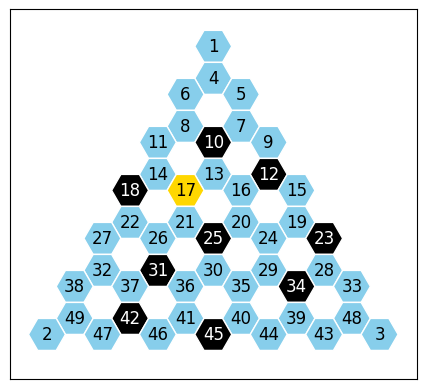

Barrier change: 42 -> 22
Barrier set 1: frozenset({34, 10, 12, 45, 18, 22, 23, 25, 31})


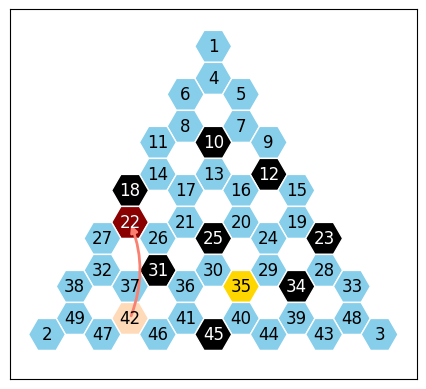

Barrier change: 23 -> 40
Barrier set 2: frozenset({34, 40, 10, 12, 45, 18, 22, 25, 31})


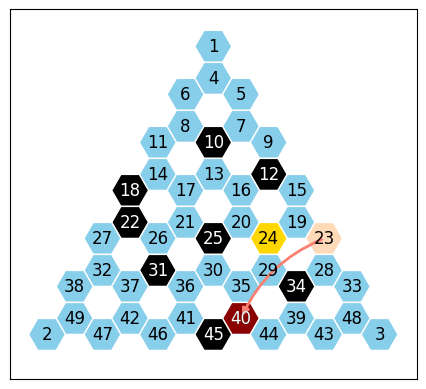

Barrier change: 22 -> 46
Barrier set 3: frozenset({34, 40, 10, 12, 45, 46, 18, 25, 31})


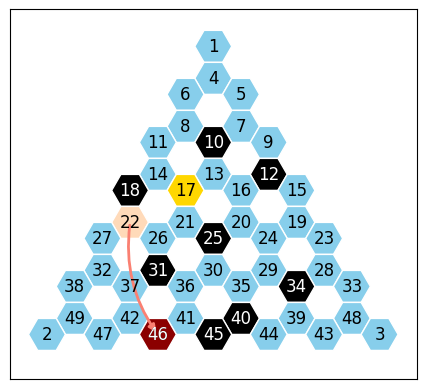

In [3]:
from hex_maze_utils import get_barrier_sequence, plot_barrier_change_sequence

original_barriers = {34, 10, 42, 12, 45, 18, 23, 25, 31}

# Given the maze database and a set of original barriers, get a potential barrier sequence
barrier_sequence = get_barrier_sequence(df, original_barriers, min_hex_diff=20, max_sequence_length=5)

# Print and plot all of the mazes in the sequence
print(f"Potential barrier sequence: {barrier_sequence}\n")
plot_barrier_change_sequence(barrier_sequence)

### Set up a database of potential barrier sequences
Usually we don't just want a single barrier sequence given a starting maze. So let's set up a database of many potential barrier sequences! 

In [ ]:
run = False # Don't run this by default because it'll take forever and prevent future cells from being run
if run:

    from tqdm import tqdm
    from hex_maze_utils import get_barrier_sequence, get_barrier_sequence_attributes

    # Load the maze configuration database
    df = pd.read_pickle('../Maze_Databases/maze_configuration_database.pkl')
    
    # Get a list of all mazes in the database so we can iterate
    all_mazes = df['barriers'].tolist()
    print(f"We have {len(all_mazes)} maze configurations to choose from!")

    # Set up a list to store the barrier sequences + info about them
    barrier_sequence_dicts = []

    # Create a database of barrier sequences (starting from mazes 5000-7000 in our maze database... using the entire database could take quite a while so sometimes we do this in chunks)
    for maze in tqdm(all_mazes[5000:7000]):

        # Find a potential barrier sequence starting with this maze
        barrier_sequence = get_barrier_sequence(df, maze, min_hex_diff=9, max_sequence_length=6, criteria_type='ALL')
    
        # Calculate attributes for this sequence
        sequence_dict = get_barrier_sequence_attributes(barrier_sequence)

        # Add it to our dictionary
        barrier_sequence_dicts.append(sequence_dict)

    # Create DataFrame
    barrier_sequence_database = pd.DataFrame(barrier_sequence_dicts)

    print("Here is our database!")
    display(barrier_sequence_database)

We have 55896 maze configurations!


100%|██████████| 2000/2000 [1:17:27<00:00,  2.32s/it]  

Here is our database!


,barrier_sequence,sequence_length,barrier_changes,reward_path_lengths,choice_points
0,"[(37, 9, 10, 45, 46, 16, 18, 25, 29), (32, 37,...",2,"[[46, 32]]","[[15, 19, 17], [17, 19, 15]]","[{26}, {36}]"
1,"[(35, 9, 10, 44, 18, 20, 22, 26, 28)]",1,[],"[[17, 19, 23]]",[{17}]
2,"[(32, 9, 44, 45, 17, 18, 20, 28, 31)]",1,[],"[[21, 17, 15]]",[{29}]
3,"[(34, 37, 7, 42, 11, 45, 17, 20, 28)]",1,[],"[[23, 19, 17]]",[{35}]
4,"[(34, 9, 10, 42, 45, 18, 25, 28, 31), (34, 9, ...",2,"[[42, 22]]","[[15, 19, 21], [21, 19, 15]]","[{17}, {35}]"
...,...,...,...,...,...
1361,"[(37, 8, 40, 12, 16, 20, 21, 27, 28)]",1,[],"[[19, 21, 15]]",[{36}]
1362,"[(35, 37, 40, 10, 14, 15, 25, 29, 30)]",1,[],"[[17, 15, 19]]",[{16}]
1363,"[(37, 7, 40, 10, 18, 20, 21, 25, 28), (36, 37,...",2,"[[21, 36]]","[[23, 19, 15], [15, 19, 21]]","[{29}, {17}]"
1364,"[(39, 8, 42, 13, 18, 19, 23, 26, 30)]",1,[],"[[21, 15, 17]]",[{29}]


### Set up a database of potential barrier sequences (with additional criteria on the mazes)

Let's say we want a barrier sequence that only includes mazes with a single choice point. We can filter the database beforehand to only include mazes that meet our criteria, and then search from there!

In [ ]:
run = False # Don't run this by default because it'll take forever and prevent future cells from being run
if run:

    from tqdm import tqdm
    from hex_maze_utils import get_barrier_sequence, get_barrier_sequence_attributes

    # Load the maze configuration database
    df = pd.read_pickle('../Maze_Databases/maze_configuration_database.pkl')

    ####### NEW STEP: FILTER THE DATABASE BASED ON YOUR CRITERIA #######
    # Filter the database to only include mazes with a single choice point
    df = df[(df['num_choice_points'] == 1)]
    
    # Get a list of all mazes in the database so we can iterate
    all_mazes = df['barriers'].tolist()
    print(f"We have {len(all_mazes)} maze configurations to choose from!")

    # Set up a list to store the barrier sequences + info about them
    barrier_sequence_dicts = []

    # Create a database of barrier sequences
    for maze in tqdm(all_mazes):

        # Find a potential barrier sequence starting with this maze
        barrier_sequence = get_barrier_sequence(df, maze, min_hex_diff=9, max_sequence_length=6, criteria_type='ALL')
    
        # Calculate attributes for this sequence
        sequence_dict = get_barrier_sequence_attributes(barrier_sequence)

        # Add it to our dictionary
        barrier_sequence_dicts.append(sequence_dict)

    # Create DataFrame
    barrier_sequence_database = pd.DataFrame(barrier_sequence_dicts)

    print("Here is our database!")
    display(barrier_sequence_database)

We have 54204 maze configurations to choose from!


100%|██████████| 54204/54204 [35:43:52<00:00,  2.37s/it]    

Here is our database!


,barrier_sequence,sequence_length,barrier_changes,reward_path_lengths,choice_points
0,"[(37, 39, 7, 41, 14, 46, 20, 23, 30), (37, 7, ...",3,"[[41, 16], [16, 17]]","[[15, 17, 21], [15, 21, 19], [25, 17, 19]]","[{13}, {26}, {29}]"
1,"[(34, 36, 37, 39, 10, 45, 14, 15, 20), (34, 37...",2,"[[36, 26]]","[[17, 21, 19], [19, 21, 17]]","[{21}, {30}]"
2,"[(34, 7, 41, 11, 46, 17, 20, 28, 31)]",1,[],"[[23, 19, 17]]",[{35}]
3,"[(34, 10, 42, 12, 45, 18, 23, 25, 31), (34, 10...",2,"[[42, 22]]","[[15, 19, 21], [21, 19, 15]]","[{17}, {35}]"
4,"[(39, 9, 10, 46, 21, 22, 23, 26, 30)]",1,[],"[[23, 17, 17]]",[{29}]
...,...,...,...,...,...
54199,"[(34, 36, 7, 10, 42, 46, 19, 22, 25)]",1,[],"[[15, 19, 21]]",[{17}]
54200,"[(37, 7, 9, 13, 45, 16, 22, 25, 29)]",1,[],"[[17, 19, 15]]",[{36}]
54201,"[(7, 39, 46, 17, 19, 22, 23, 24, 30)]",1,[],"[[17, 23, 17]]",[{31}]
54202,"[(34, 10, 11, 42, 45, 15, 22, 25, 30), (34, 7,...",2,"[[11, 7]]","[[17, 15, 19], [15, 17, 19]]","[{16}, {17}]"


### Let's take a look at our generated database.

How many sequences in the database are at least 3 mazes long? How many are 6 mazes long?

In [23]:
# Add a description of how this database was generated in the attributes of the dataframe
barrier_sequence_database.attrs['description'] = 'Barrier sequence database where all mazes have a single choice point. Min hex diff = 9, criteria_type = ALL'
print(barrier_sequence_database.attrs)

# How many sequences in this database are at least 3 mazes long?
filtered = barrier_sequence_database[barrier_sequence_database['sequence_length'] >= 3]
print(f"There are {len(filtered)} barrier sequences in our database that are at least 3 mazes long:")
display(filtered)

# How many sequences in this database are 6 mazes long?
filtered = barrier_sequence_database[barrier_sequence_database['sequence_length'] == 6]
print(f"There are {len(filtered)} barrier sequences in our database that are 6 mazes long:")
display(filtered)

{'description': 'Barrier sequence database where all mazes have a single choice point. Min hex diff = 9, criteria_type = ALL'}
There are 3720 barrier sequences in our database that are at least 3 mazes long:


,barrier_sequence,sequence_length,barrier_changes,reward_path_lengths,choice_points
0,"[(37, 39, 7, 41, 14, 46, 20, 23, 30), (37, 7, ...",3,"[[41, 16], [16, 17]]","[[15, 17, 21], [15, 21, 19], [25, 17, 19]]","[{13}, {26}, {29}]"
15,"[(8, 42, 12, 44, 46, 16, 21, 27, 30), (8, 42, ...",3,"[[16, 29], [30, 16]]","[[17, 23, 17], [17, 15, 21], [17, 23, 17]]","[{31}, {13}, {31}]"
25,"[(39, 42, 11, 13, 19, 22, 25, 27, 30), (39, 42...",3,"[[11, 16], [25, 26]]","[[21, 15, 17], [15, 21, 17], [23, 17, 17]]","[{29}, {31}, {29}]"
33,"[(34, 36, 37, 7, 45, 14, 17, 20, 28), (34, 36,...",3,"[[17, 25], [36, 26]]","[[23, 19, 17], [15, 19, 23], [21, 19, 15]]","[{35}, {13}, {35}]"
44,"[(32, 34, 11, 44, 13, 46, 15, 21, 30), (32, 34...",3,"[[13, 16], [21, 26]]","[[21, 15, 19], [17, 25, 19], [23, 17, 19]]","[{24}, {31}, {24}]"
...,...,...,...,...,...
54141,"[(37, 7, 42, 45, 14, 20, 23, 25, 29), (37, 7, ...",3,"[[42, 27], [29, 35]]","[[15, 19, 17], [17, 19, 15], [17, 17, 23]]","[{26}, {36}, {13}]"
54156,"[(7, 42, 44, 14, 20, 23, 28, 30, 31), (7, 42, ...",3,"[[31, 26], [30, 35]]","[[15, 17, 21], [23, 17, 17], [17, 17, 23]]","[{13}, {29}, {13}]"
54158,"[(36, 39, 8, 10, 42, 19, 21, 24, 27), (39, 8, ...",4,"[[36, 30], [24, 17], [21, 24]]","[[19, 17, 23], [19, 25, 17], [21, 15, 17], [17...","[{16}, {31}, {29}, {31}]"
54160,"[(37, 8, 9, 45, 20, 21, 23, 27, 29), (35, 37, ...",3,"[[29, 35], [20, 16]]","[[19, 21, 15], [19, 17, 25], [19, 23, 17]]","[{36}, {13}, {36}]"


There are 104 barrier sequences in our database that are 6 mazes long:


,barrier_sequence,sequence_length,barrier_changes,reward_path_lengths,choice_points
417,"[(35, 37, 7, 40, 14, 20, 27, 28, 31), (37, 7, ...",6,"[[35, 25], [31, 15], [27, 46], [15, 30], [30, ...","[[17, 17, 23], [21, 17, 15], [17, 19, 15], [15...","[{13}, {29}, {36}, {26}, {13}, {29}]"
1339,"[(37, 7, 40, 14, 46, 15, 20, 25, 28), (37, 7, ...",6,"[[46, 27], [15, 30], [30, 31], [27, 42], [31, ...","[[15, 19, 17], [17, 19, 15], [17, 17, 23], [21...","[{26}, {36}, {13}, {29}, {13}, {29}]"
2666,"[(39, 8, 42, 10, 13, 19, 22, 24, 30), (39, 8, ...",6,"[[24, 25], [13, 35], [8, 9], [35, 21], [21, 13]]","[[17, 23, 17], [21, 15, 17], [17, 15, 19], [15...","[{31}, {29}, {16}, {17}, {29}, {31}]"
4514,"[(37, 7, 40, 42, 14, 15, 20, 25, 28), (37, 7, ...",6,"[[15, 21], [21, 31], [42, 27], [31, 15], [15, ...","[[15, 19, 17], [23, 17, 17], [15, 17, 21], [21...","[{26}, {29}, {13}, {29}, {36}, {13}]"
4698,"[(35, 39, 8, 10, 42, 19, 22, 25, 30), (39, 8, ...",6,"[[35, 20], [20, 13], [8, 9], [13, 21], [21, 35]]","[[17, 15, 19], [17, 23, 17], [21, 15, 17], [15...","[{16}, {31}, {29}, {31}, {29}, {17}]"
...,...,...,...,...,...
49566,"[(39, 42, 10, 13, 17, 19, 22, 24, 30), (39, 42...",6,"[[24, 25], [17, 9], [13, 21], [21, 35], [9, 8]]","[[17, 23, 17], [21, 15, 17], [15, 21, 17], [23...","[{31}, {29}, {31}, {29}, {17}, {16}]"
50668,"[(37, 7, 40, 14, 20, 25, 26, 28, 31), (37, 7, ...",6,"[[26, 42], [31, 21], [21, 15], [42, 27], [15, ...","[[21, 17, 15], [15, 17, 21], [23, 17, 17], [15...","[{29}, {13}, {29}, {26}, {36}, {13}]"
51154,"[(32, 34, 8, 41, 12, 16, 21, 25, 29), (32, 34,...",6,"[[16, 44], [29, 16], [16, 17], [44, 28], [17, ...","[[17, 21, 15], [17, 15, 21], [17, 23, 17], [19...","[{31}, {13}, {31}, {24}, {35}, {13}]"
53313,"[(37, 7, 40, 14, 20, 24, 25, 27, 28), (37, 7, ...",6,"[[27, 46], [24, 17], [17, 31], [46, 27], [25, ...","[[17, 19, 15], [15, 19, 17], [23, 17, 17], [15...","[{36}, {26}, {29}, {13}, {29}, {13}]"


### Let's plot a sequence from our database.

See [`Plotting_Hex_Mazes.ipynb`](Plotting_Hex_Mazes.ipynb) for a complete description of plotting options, and modify the arguments to `plot_barrier_change_sequence` to display the mazes in a way that suits you.

,barrier_sequence,sequence_length,barrier_changes,reward_path_lengths,choice_points
417,"[(35, 37, 7, 40, 14, 20, 27, 28, 31), (37, 7, ...",6,"[[35, 25], [31, 15], [27, 46], [15, 30], [30, ...","[[17, 17, 23], [21, 17, 15], [17, 19, 15], [15...","[{13}, {29}, {36}, {26}, {13}, {29}]"
1339,"[(37, 7, 40, 14, 46, 15, 20, 25, 28), (37, 7, ...",6,"[[46, 27], [15, 30], [30, 31], [27, 42], [31, ...","[[15, 19, 17], [17, 19, 15], [17, 17, 23], [21...","[{26}, {36}, {13}, {29}, {13}, {29}]"
2666,"[(39, 8, 42, 10, 13, 19, 22, 24, 30), (39, 8, ...",6,"[[24, 25], [13, 35], [8, 9], [35, 21], [21, 13]]","[[17, 23, 17], [21, 15, 17], [17, 15, 19], [15...","[{31}, {29}, {16}, {17}, {29}, {31}]"
4514,"[(37, 7, 40, 42, 14, 15, 20, 25, 28), (37, 7, ...",6,"[[15, 21], [21, 31], [42, 27], [31, 15], [15, ...","[[15, 19, 17], [23, 17, 17], [15, 17, 21], [21...","[{26}, {29}, {13}, {29}, {36}, {13}]"
4698,"[(35, 39, 8, 10, 42, 19, 22, 25, 30), (39, 8, ...",6,"[[35, 20], [20, 13], [8, 9], [13, 21], [21, 35]]","[[17, 15, 19], [17, 23, 17], [21, 15, 17], [15...","[{16}, {31}, {29}, {31}, {29}, {17}]"
...,...,...,...,...,...
49566,"[(39, 42, 10, 13, 17, 19, 22, 24, 30), (39, 42...",6,"[[24, 25], [17, 9], [13, 21], [21, 35], [9, 8]]","[[17, 23, 17], [21, 15, 17], [15, 21, 17], [23...","[{31}, {29}, {31}, {29}, {17}, {16}]"
50668,"[(37, 7, 40, 14, 20, 25, 26, 28, 31), (37, 7, ...",6,"[[26, 42], [31, 21], [21, 15], [42, 27], [15, ...","[[21, 17, 15], [15, 17, 21], [23, 17, 17], [15...","[{29}, {13}, {29}, {26}, {36}, {13}]"
51154,"[(32, 34, 8, 41, 12, 16, 21, 25, 29), (32, 34,...",6,"[[16, 44], [29, 16], [16, 17], [44, 28], [17, ...","[[17, 21, 15], [17, 15, 21], [17, 23, 17], [19...","[{31}, {13}, {31}, {24}, {35}, {13}]"
53313,"[(37, 7, 40, 14, 20, 24, 25, 27, 28), (37, 7, ...",6,"[[27, 46], [24, 17], [17, 31], [46, 27], [25, ...","[[17, 19, 15], [15, 19, 17], [23, 17, 17], [15...","[{36}, {26}, {29}, {13}, {29}, {13}]"


Barrier set 0: frozenset({np.int64(39), np.int64(8), np.int64(42), np.int64(10), np.int64(13), np.int64(19), np.int64(22), np.int64(24), np.int64(30)})


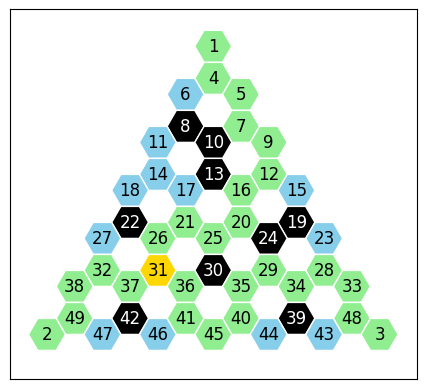

Barrier change: 24 -> 25
Barrier set 1: frozenset({39, 8, 10, 42, 13, 19, 22, 25, 30})


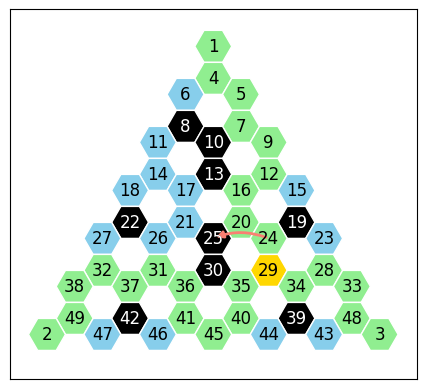

Barrier change: 13 -> 35
Barrier set 2: frozenset({35, 39, 8, 10, 42, 19, 22, 25, 30})


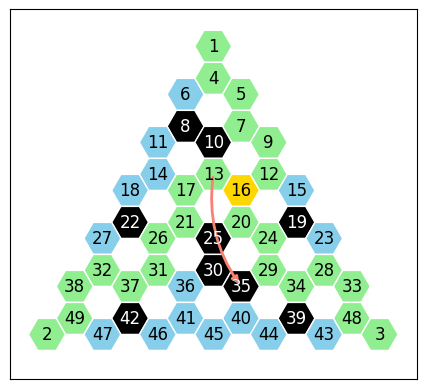

Barrier change: 8 -> 9
Barrier set 3: frozenset({35, 39, 9, 10, 42, 19, 22, 25, 30})


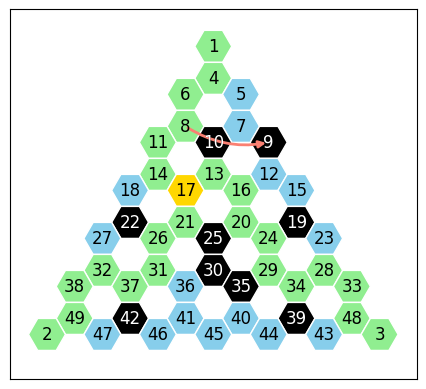

Barrier change: 35 -> 21
Barrier set 4: frozenset({39, 9, 42, 10, 19, 21, 22, 25, 30})


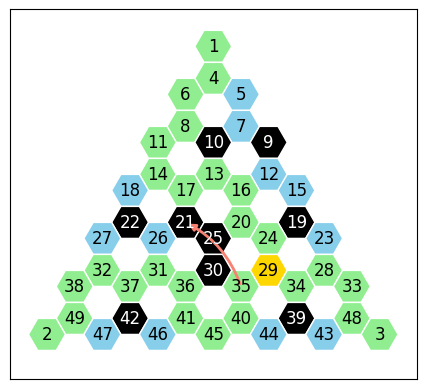

Barrier change: 21 -> 13
Barrier set 5: frozenset({39, 9, 10, 42, 13, 19, 22, 25, 30})


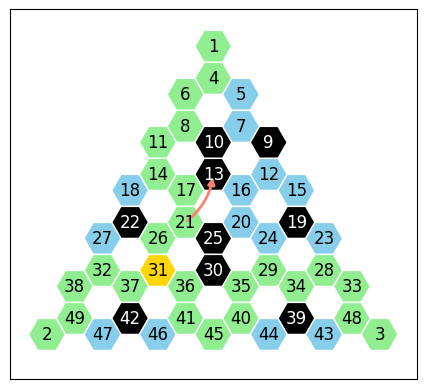

In [22]:
from hex_maze_utils import plot_barrier_change_sequence

# Filter the database to only sequences that are 6 mazes long
filtered = barrier_sequence_database[barrier_sequence_database['sequence_length'] == 6]
display(filtered)

# Grab a sequence from the filtered database (here, sequence 2)
sequence = filtered['barrier_sequence'].iloc[2]

# Plot the sequence (highlighting optimal paths in green)
plot_barrier_change_sequence(sequence, show_barriers=True, show_barrier_change=False, show_optimal_paths=True)

### Save the database for future use

We don't want to regenerate these every time! Save the database using a descriptive name so in the future you can load it and search for the sequence you want.

In [27]:
# Give your database a descriptive and UNIQUE name (duplicate names will overwrite existing files!!)
database_name = "descriptive_name_of_these_barrier_sequences"

save = False # be warned that saving will overwrite already saved files of the same name

if save:
    # Save the database as a CSV for readability without loading in a notebook
    barrier_sequence_database.to_csv(f'../Barrier_Sequence_Databases/{database_name}.csv', index=False)
    
    # Also save the database using pickle - this preserves datatypes and metadata for loading in notebooks
    barrier_sequence_database.to_pickle(f'../Barrier_Sequence_Databases/{database_name}.pkl')

### Loading the database for use in your notebooks

IMPORTANT: Make sure to load the pickle (.pkl) version instead of the csv (.csv) version - the csv version loads variables as strings and messes things up. 

In [28]:
# Load the database
barrier_sequences = pd.read_pickle('../Barrier_Sequence_Databases/single_choice_point.pkl')
display(barrier_sequences)

,barrier_sequence,sequence_length,barrier_changes,reward_path_lengths,choice_points
0,"[(37, 7, 39, 41, 14, 46, 20, 23, 30), (37, 39,...",3,"[[41, 16], [16, 17]]","[[15, 17, 21], [15, 21, 19], [25, 17, 19]]","[{13}, {26}, {29}]"
15,"[(8, 42, 12, 44, 46, 16, 21, 27, 30), (8, 42, ...",3,"[[16, 29], [30, 16]]","[[17, 23, 17], [17, 15, 21], [17, 23, 17]]","[{31}, {13}, {31}]"
25,"[(39, 42, 11, 13, 19, 22, 25, 27, 30), (39, 42...",3,"[[11, 16], [25, 26]]","[[21, 15, 17], [15, 21, 17], [23, 17, 17]]","[{29}, {31}, {29}]"
33,"[(34, 36, 37, 7, 45, 14, 17, 20, 28), (34, 36,...",3,"[[17, 25], [36, 26]]","[[23, 19, 17], [15, 19, 23], [21, 19, 15]]","[{35}, {13}, {35}]"
44,"[(32, 34, 11, 44, 13, 46, 15, 21, 30), (32, 34...",3,"[[13, 16], [21, 26]]","[[21, 15, 19], [17, 25, 19], [23, 17, 19]]","[{24}, {31}, {24}]"
...,...,...,...,...,...
54141,"[(37, 7, 42, 45, 14, 20, 23, 25, 29), (37, 7, ...",3,"[[42, 27], [29, 35]]","[[15, 19, 17], [17, 19, 15], [17, 17, 23]]","[{26}, {36}, {13}]"
54156,"[(7, 42, 44, 14, 20, 23, 28, 30, 31), (7, 42, ...",3,"[[31, 26], [30, 35]]","[[15, 17, 21], [23, 17, 17], [17, 17, 23]]","[{13}, {29}, {13}]"
54158,"[(36, 39, 8, 10, 42, 19, 21, 24, 27), (39, 8, ...",4,"[[36, 30], [24, 17], [21, 24]]","[[19, 17, 23], [19, 25, 17], [21, 15, 17], [17...","[{16}, {31}, {29}, {31}]"
54160,"[(37, 8, 9, 45, 20, 21, 23, 27, 29), (35, 37, ...",3,"[[29, 35], [20, 16]]","[[19, 21, 15], [19, 17, 25], [19, 23, 17]]","[{36}, {13}, {36}]"
